 ## Chapter 4: Implementing a GPT model from Scratch To Generate Text

In [2]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

In [3]:
print("matplotlib version", version("matplotlib"))
print("torch version", version("torch"))
print("tiktoken varsion", version("tiktoken"))

matplotlib version 3.8.3
torch version 2.1.1
tiktoken varsion 0.3.3


* chapter 1 discussed model like GPT and Llama, which generate words sequentially and are based on the decoder part of the original tarnsformer architecture

* therefore these LLM's are often referred to as decoder-like LLm's

* compared to conventional deep learning models, LLM are larger mainly due to their vast number of parameters not the amount od code

* wwe will see that many elements are repeated in an LLm architecture

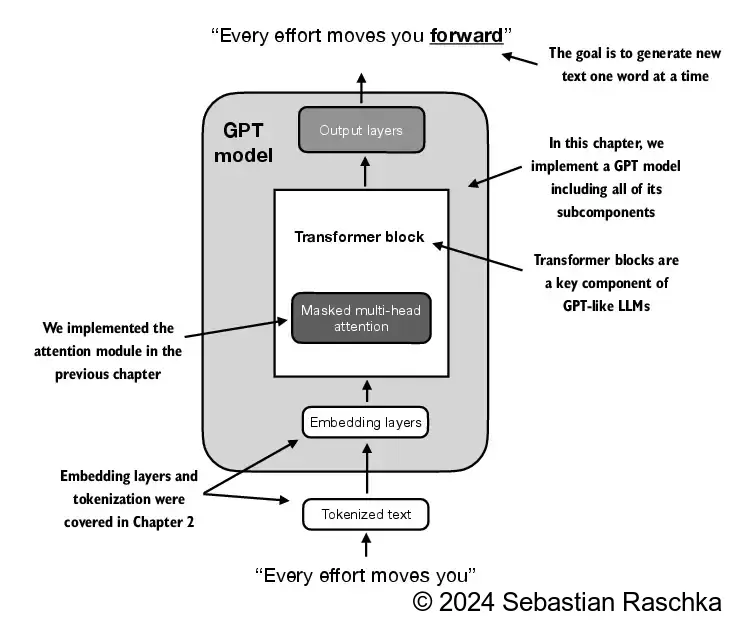

* in the previous chaters we used small embeddings dimensions for token inputs and output for ease of illustration, ensuring thay fit on a single page

* In this chapter, we consider embedding and model sizes akin to a small GPT-2 model

* We'll specifically code the architecture of the smallest GPT-2 model (124 million parameters), as outlined in Radford et al.'s Language Models are Unsupervised Multitask Learners (note that the initial report lists it as 117M parameters, but this was later corrected in the model weight repository)

* Chapter 6 will show how to load pretrained weights into our implementation, which will be compatible with model sizes of 345, 762, and 1542 million parameters
 

* Configuration details for the 124 million parameter GPT-2 model include:


In [4]:
GPT_CONFIG_124 = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "emb_dim" : 768,
    "n_heads" :12,
    "n_layers" : 12,
    "drop_rate" :0.1,
    "qkv_bias" : False
}


* We use short variable names to avoid long lines of code later

* "vocab_size" indicates a vocabulary size of 50,257 words, supported by the BPE tokenizer discussed in Chapter 2

* "context_length" represents the model's maximum input token count, as enabled by positional embeddings covered in Chapter 2

* "emb_dim" is the embedding size for token inputs, converting each input token into a 768-dimensional vector

* "n_heads" is the number of attention heads in the multi-head attention mechanism implemented in Chapter 3

* "n_layers" is the number of transformer blocks within the model, which we'll implement in upcoming sections

* "drop_rate" is the dropout mechanism's intensity, discussed in Chapter 3; 0.1 means dropping 10% of hidden units during training to mitigate overfitting

* "qkv_bias" decides if the Linear layers in the multi-head attention mechanism (from Chapter 3) should include a bias vector when computing query (Q), key (K), and value (V) tensors; we'll disable this option, which is standard practice in modern LLMs; however, we'll revisit this later when loading pretrained GPT-2 weights from OpenAI into our reimplementation in chapter 5

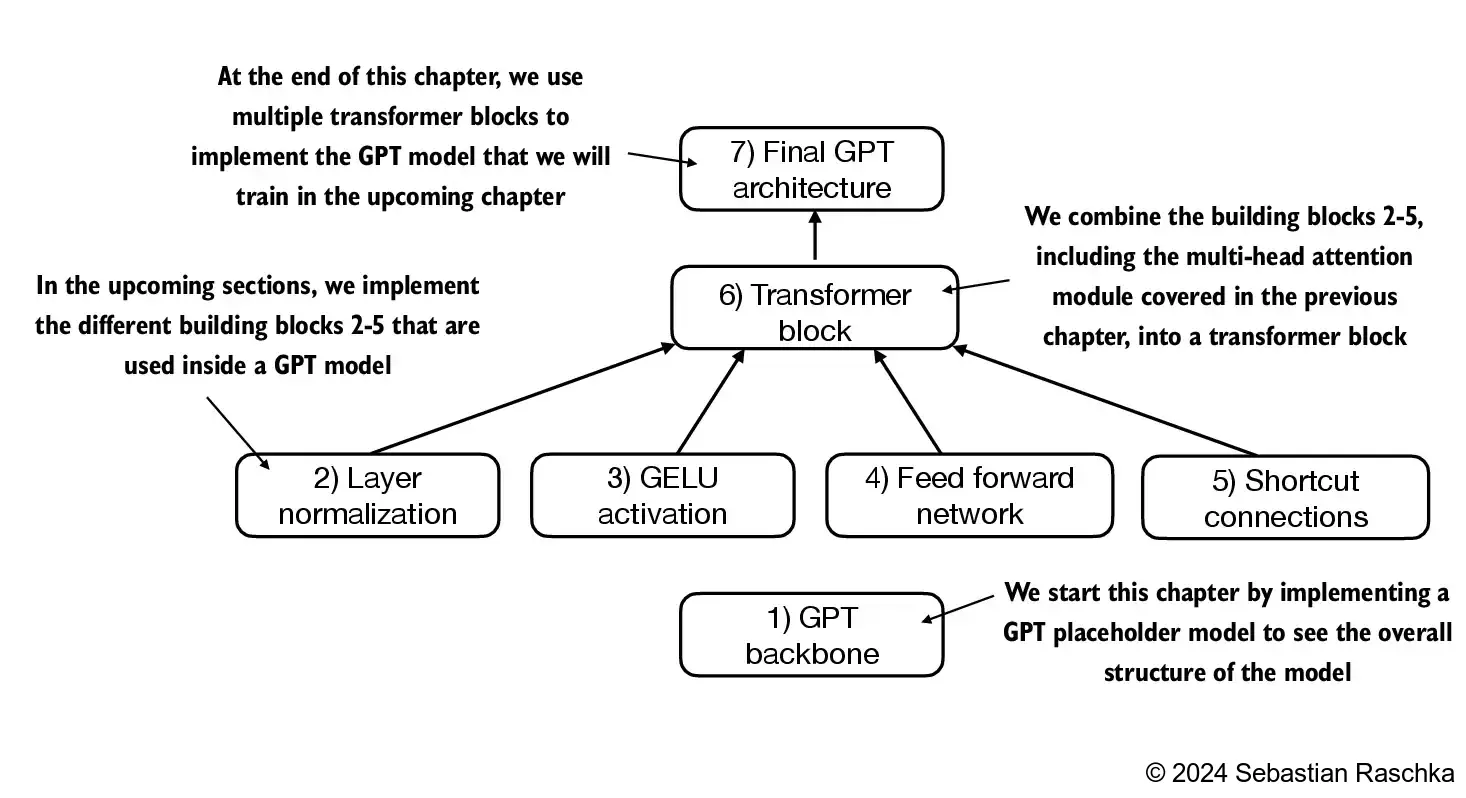

In [5]:
import torch 
import torch.nn as nn 

class DummyGPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )

        self.final_norm = DummyLayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(
            cfg['emb_dim'], cfg['vocab_size'], bias = False
        )


    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_emb = self.tok_emb(in_idx)
        pos_emb = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_emb +pos_emb
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    

class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()


    def forward(self, x):

        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalisez_shape, eps = 1e-5):
        super().__init__()

    def forward(self, x):
        return x




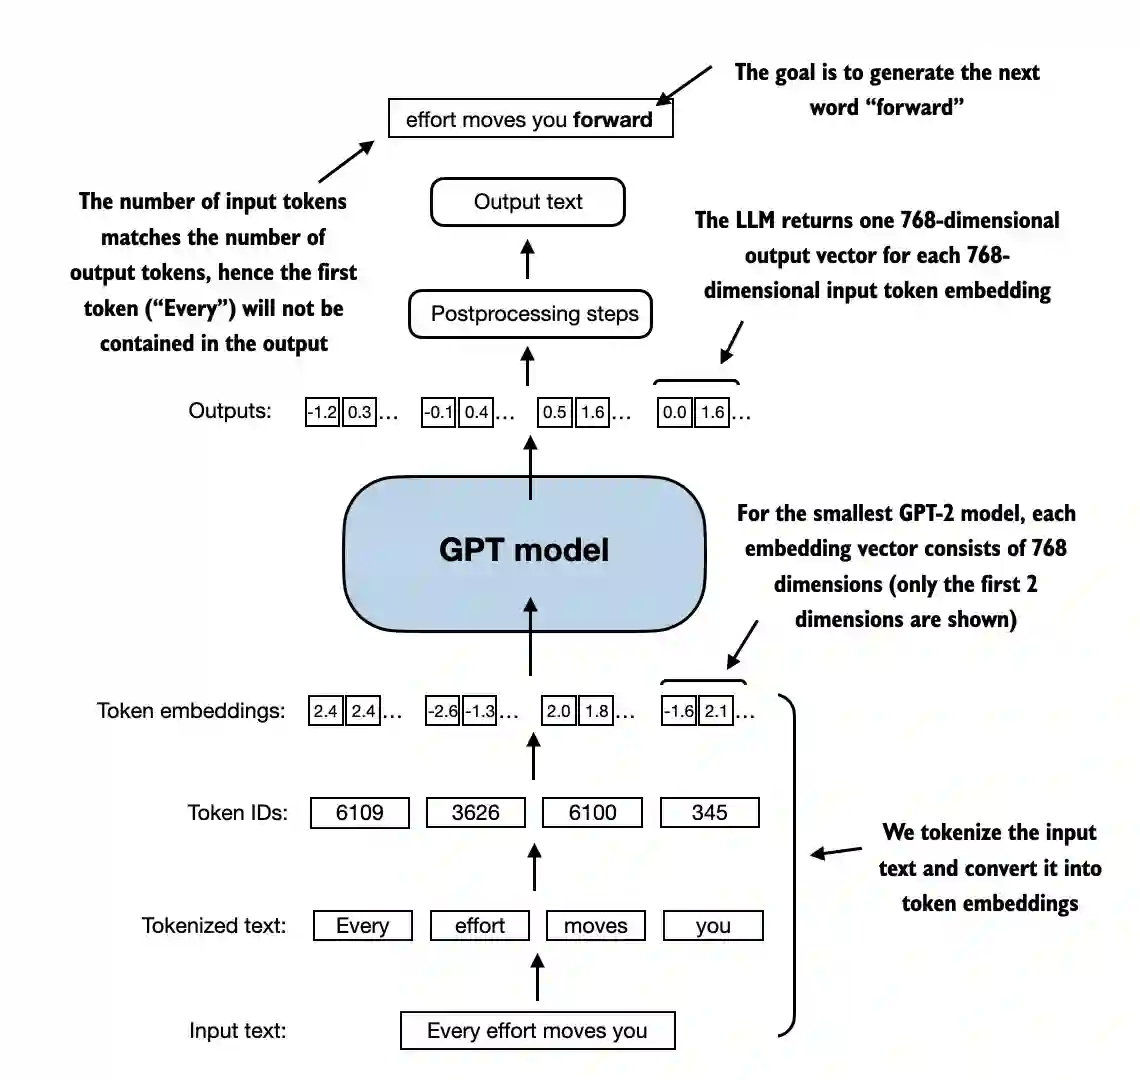

In [6]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [7]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124)

logits = model(batch)
print("output shape: ", logits.shape)
print(logits)

output shape:  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0448,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


## 4.2 Normalizing activations with layer normalization

* Layer normalization, also known as LayerNorm (Ba et al. 2016), centers the activations of a neural network layer around a mean of 0 and normalizes their variance to 1

* This stabilizes training and enables faster convergence to effective weights

* Layer normalization is applied both before and after the multi-head attention module within the transformer block, which we will implement later; it's also applied before the final output layer

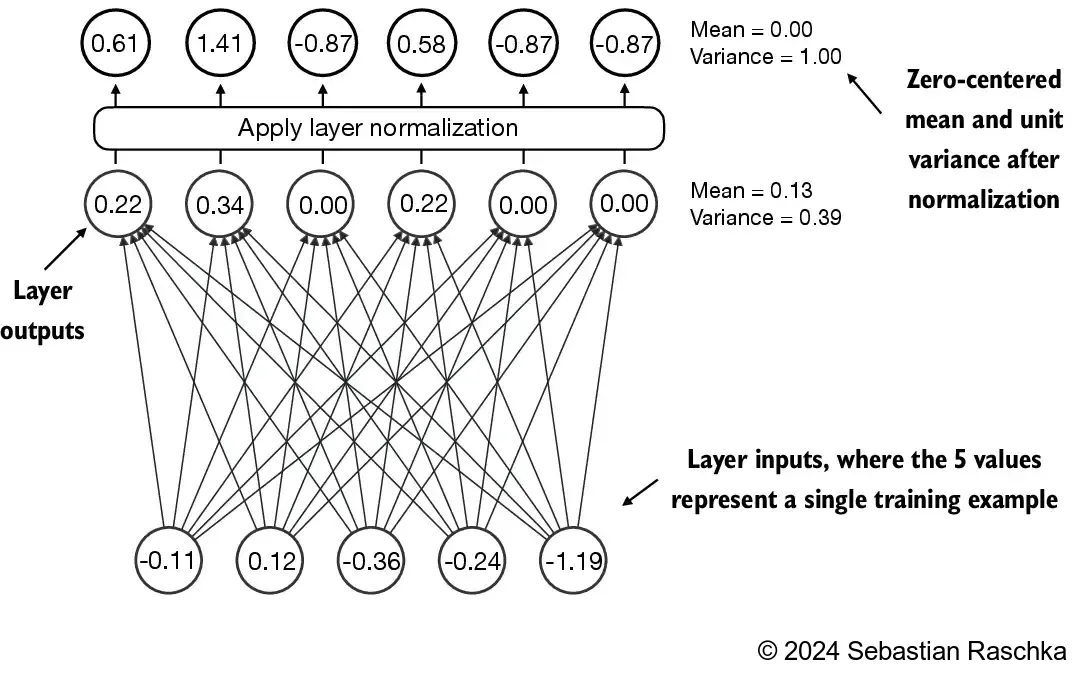

* Let's see how layer normalization works by passing a small input sample through a simple neural network layer:

In [8]:
torch.manual_seed(123)
batch_example = torch.randn(2,5)

layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())

out = layer(batch_example)

print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [9]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim = -1, keepdim=True)

* The normalization is applied to each of the two inputs (rows) independently; using dim=-1 applies the calculation across the last dimension (in this case, the feature dimension) instead of the row dimension

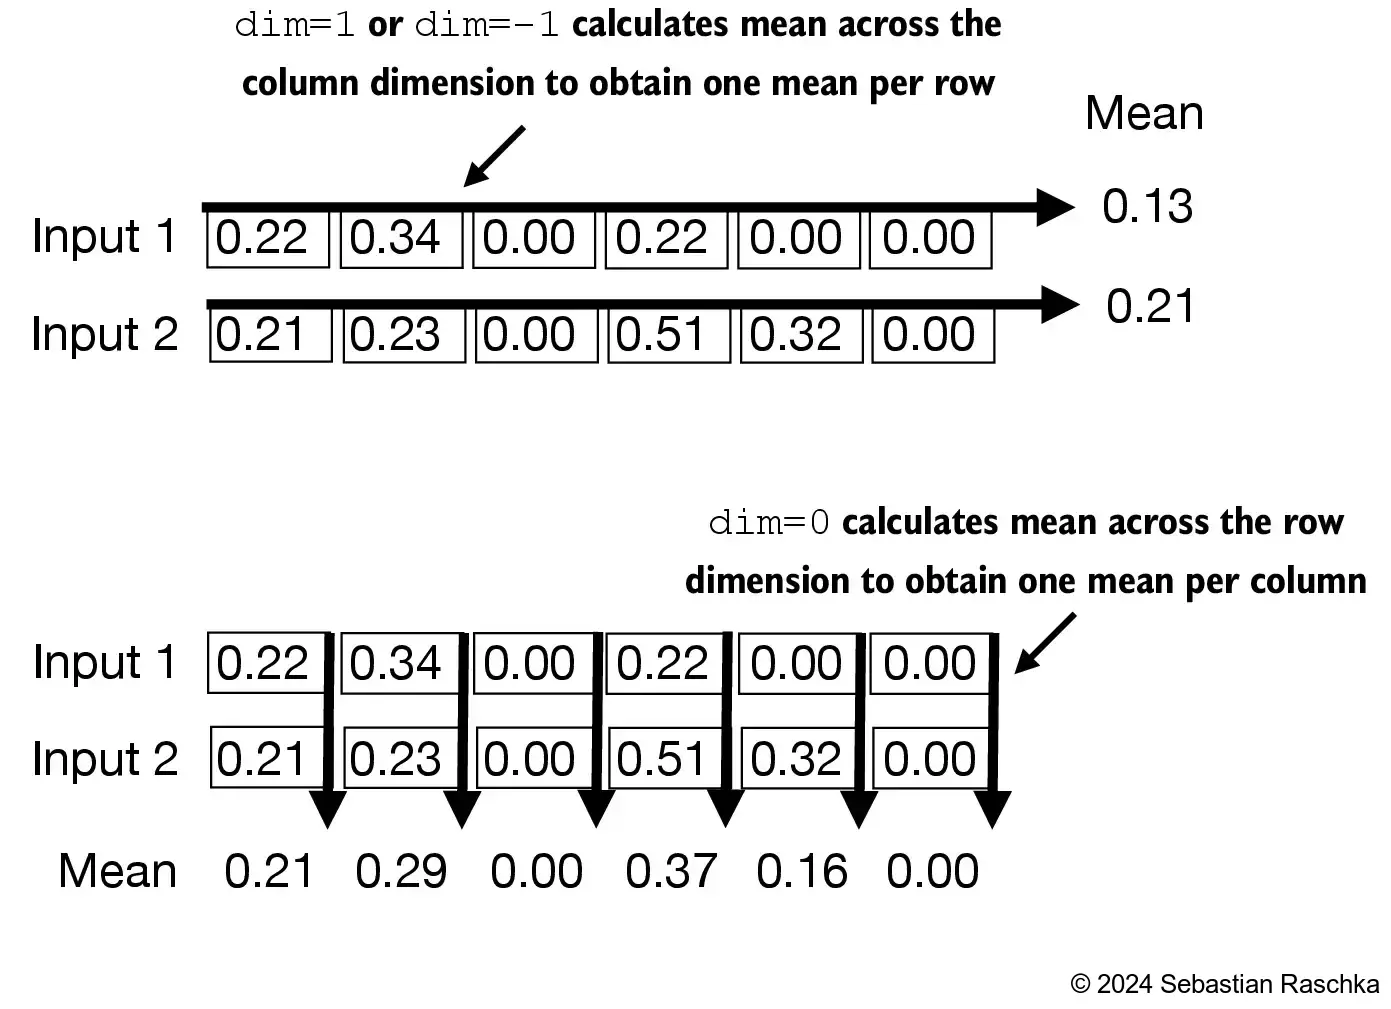

* Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [10]:
out_norm = (out - mean) / torch.sqrt(var)

* Each input is centered at 0 and has a unit variance of 1; to improve readability, we can disable PyTorch's scientific notation:

* Now, using the same idea, we can implement a LayerNorm class:


In [11]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.emb_dim = emb_dim
        self.alpha = nn.Parameter(torch.ones(self.emb_dim))
        self.bias = nn.Parameter(torch.zeros(self.emb_dim))


    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim = -1, keepdim=True, unbiased = False)
        numerator = (x-mean)
        denomerator = torch.sqrt(var + self.eps)
        out = numerator / denomerator
        return self.alpha* out + self.bias

* Note that in addition to performing the normalization by subtracting the mean and dividing by the variance, we added two trainable parameters, a scale and a shift parameter

* The initial scale (multiplying by 1) and shift (adding 0) values don't have any effect; however, scale and shift are trainable parameters that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task

* This allows the model to learn appropriate scaling and shifting that best suit the data it is processing

* Note that we also add a smaller value (eps) before computing the square root of the variance; this is to avoid division-by-zero errors if the variance is 0

#### biased variance

* In the variance calculation above, setting unbiased=False means using the formula     to compute the variance where n is the sample size (here, the number of features or columns); this formula does not include Bessel's correction (which uses n-1 in the denominator), thus providing a biased estimate of the variance

* For LLMs, where the embedding dimension n is very large, the difference between using n and n-1 is negligible

* However, GPT-2 was trained with a biased variance in the normalization layers, which is why we also adopted this setting for compatibility reasons with the pretrained weights that we will load in later chapters

* Let's now try out LayerNorm in practice:

In [12]:
ln = LayerNorm(emb_dim=5)

out_ln = ln(batch_example)

### Implementing a feed forward netword with GELU activations

* in this section we implement a small neural network submodule that is used as part of the transformer block in LLM's

* we start with the activation function

* in deep learning relu actiivation function are commonly used due to their simplecity and effectiveness in various neural netword architecture.

* In LLMs, various other types of activation functions are used beyond the traditional ReLU; two notable examples are GELU (Gaussian Error Linear Unit) and SwiGLU (Swish-Gated Linear Unit)

* GELU and SwiGLU are more complex, smooth activation functions incorporating Gaussian and sigmoid-gated linear units, respectively, offering better performance for deep learning models, unlike the simpler, piecewise linear function of ReLU

* GELU (Hendrycks and Gimpel 2016) can be implemented in several ways; the exact version is defined as GELU(x)=x⋅Φ(x), where Φ(x) is the cumulative distribution function of the standard Gaussian distribution.

* In practice, it's common to implement a computationally cheaper approximation: 
 
 (the original GPT-2 model was also trained with this approximation)

In [16]:

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

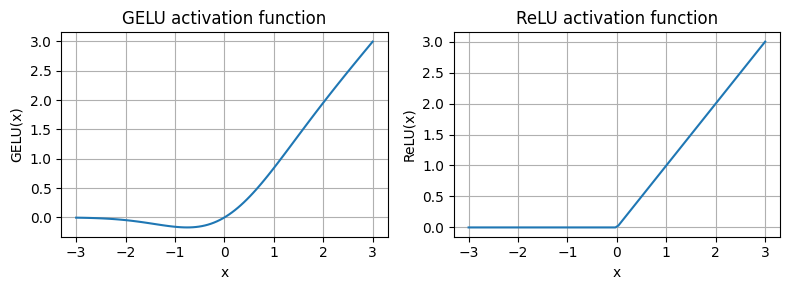

In [17]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()




* As we can see, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero

* GELU is a smooth, non-linear function that approximates ReLU but with a non-zero gradient for negative values (except at approximately -0.75)

* Next, let's implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:

In [18]:
class feedforward(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4*cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )

    def forward(self, x):
        return self.layers(x)

In [19]:
ffn = feedforward(GPT_CONFIG_124)

x = torch.randn(2,3, 768)
out = ffn(x)
print(out)

tensor([[[-0.3731, -0.2161,  0.1972,  ..., -0.2462,  0.0535,  0.2413],
         [ 0.0069,  0.0609,  0.3952,  ...,  0.1626, -0.0415, -0.1237],
         [ 0.1569, -0.1565, -0.0789,  ..., -0.3007,  0.2389, -0.1702]],

        [[ 0.2887,  0.0783,  0.1038,  ..., -0.2605, -0.0504, -0.2268],
         [-0.0889,  0.2274,  0.0563,  ..., -0.2062,  0.0148, -0.2420],
         [ 0.2520, -0.0005, -0.2848,  ..., -0.0739, -0.0354,  0.0410]]],
       grad_fn=<ViewBackward0>)


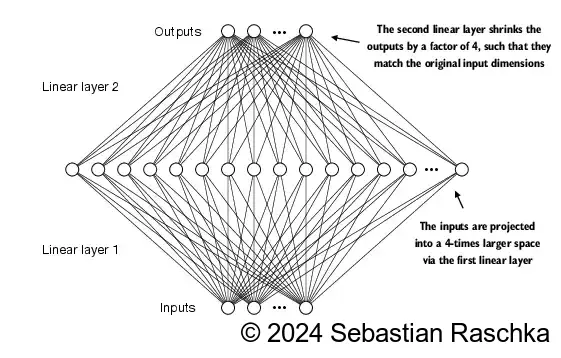

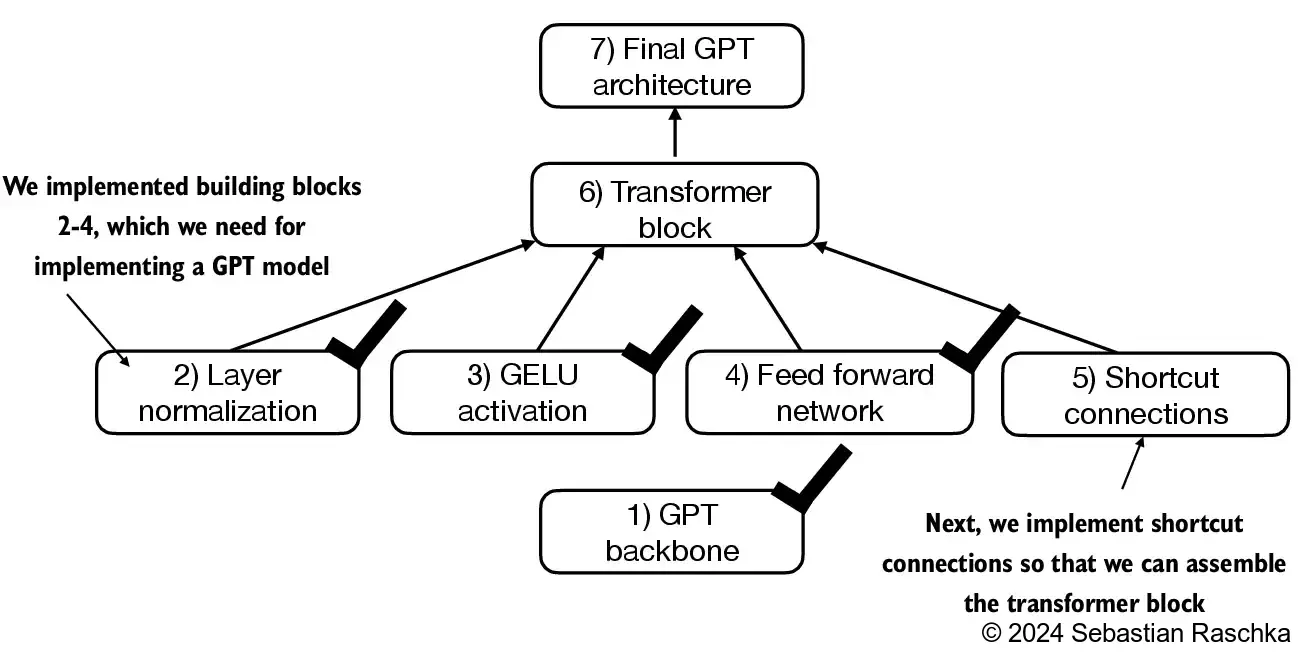

### 4.4 Adding shortcut connections



* Next, let's talk about the concept behind shortcut connections, also called skip or residual connections

* Originally, shortcut connections were proposed in deep networks for computer vision (residual networks) to mitigate vanishing gradient problems

* A shortcut connection creates an alternative shorter path for the gradient to flow through the network

* This is achieved by adding the output of one layer to the output of a later layer, usually skipping one or more layers in between

* Let's illustrate this idea with a small example network:

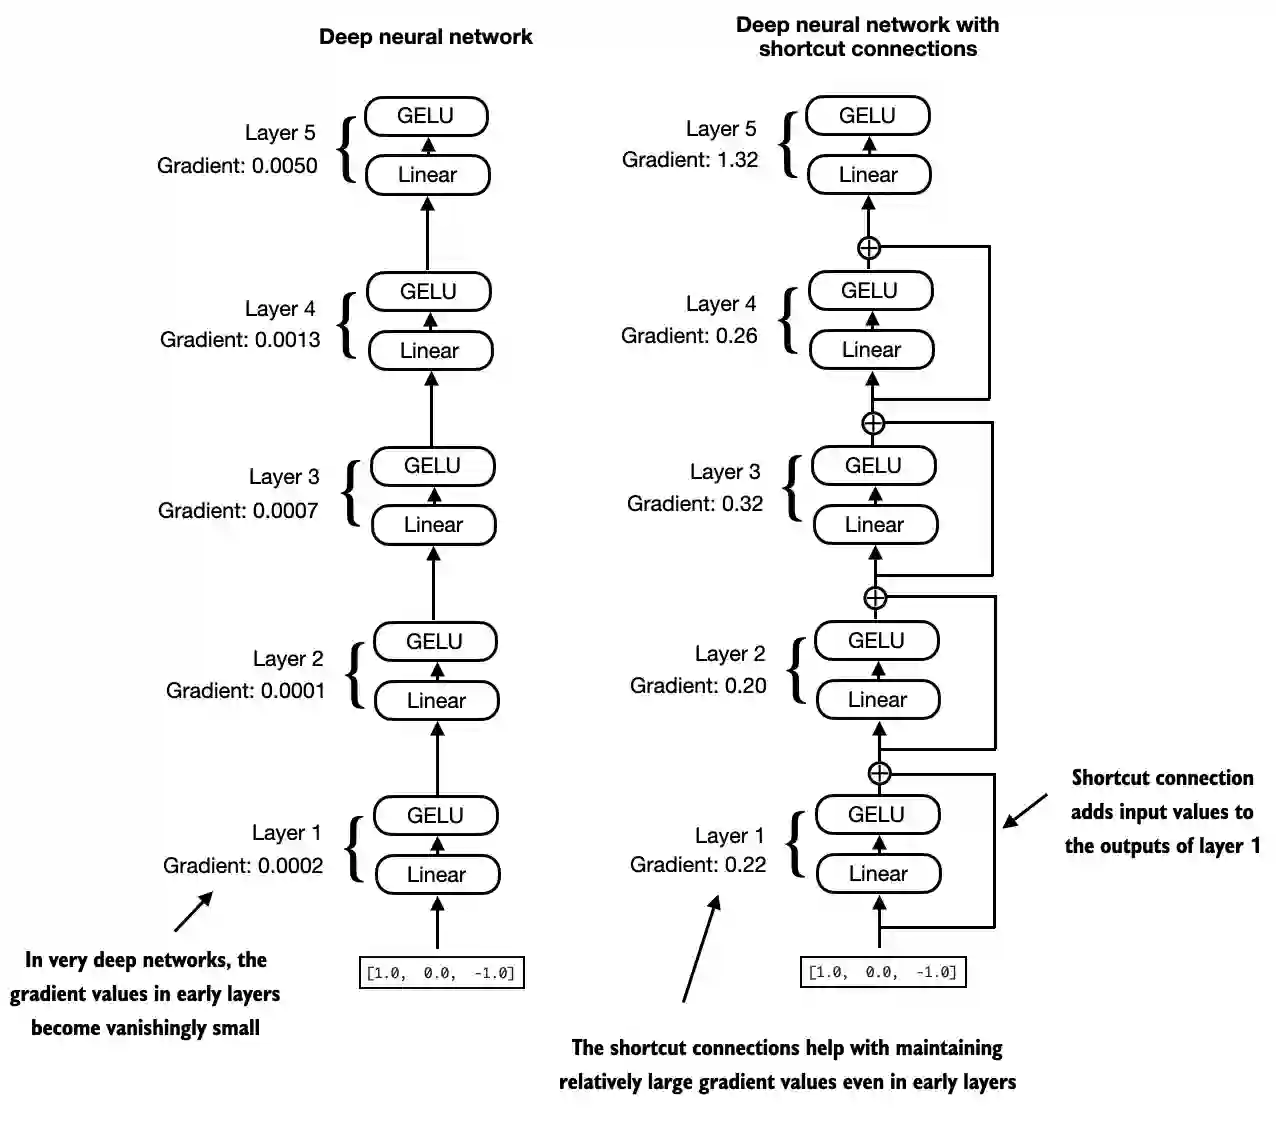

In [20]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forwrad(self, x):
        for layer in self.layers:
            layer_output = layer(x)

            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else :
                x = layer_output
        return x
    
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")